<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contrôle-de-la-qualité-des-datasets" data-toc-modified-id="Contrôle-de-la-qualité-des-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Contrôle de la qualité des datasets</a></span></li><li><span><a href="#Sélection-des-features" data-toc-modified-id="Sélection-des-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sélection des features</a></span><ul class="toc-item"><li><span><a href="#A-l'aide-d'un-LASSO" data-toc-modified-id="A-l'aide-d'un-LASSO-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A l'aide d'un LASSO</a></span></li><li><span><a href="#A-l'aide-d'un-RandomForestRegressor-naif" data-toc-modified-id="A-l'aide-d'un-RandomForestRegressor-naif-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>A l'aide d'un RandomForestRegressor naif</a></span></li></ul></li><li><span><a href="#Développement-de-la-Pipeline-avec-XGBoost" data-toc-modified-id="Développement-de-la-Pipeline-avec-XGBoost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Développement de la Pipeline avec XGBoost</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

In [2]:
train= pd.read_csv("../good_data/donnees_model/donnees_train.csv")
test= pd.read_csv("../good_data/donnees_model/donnees_test.csv")
valid= pd.read_csv("../good_data/donnees_model/donnees_validation.csv")

## Contrôle de la qualité des datasets

In [3]:
def dim_df(df):
    return df.shape[0], df.shape[1]

# Check we have the same number of col
assert dim_df(train)[1] == dim_df(test)[1] == dim_df(valid)[1]

In [5]:
# To iterate dataset into for bound
stock_dico= {"train": train, "test": test, "valid": valid}
listed_index= [i for i in stock_dico.keys()]
# Some column are useless 
useless_col= ["Unnamed: 0", "idmutation", "FR", "Ind", "irl", "geometry", "arrondissement", "year"
             , "valeurfo_1", "valeurfo_2", "valeurfo_3", "rate_cumpr", "IdINSPIRE", "datemut"
             , "l_codinsee", "libtypbien", "valfoncact", "sbati_squa"]

not_object_col= [i for i in train.columns if train[i].dtypes != "object" and i not in useless_col]
print("On a {} colonne à analyser".format(len(not_object_col)))

diff_df= pd.DataFrame()
for i in not_object_col:
    tr= train[i]
    tt= test[i]
    vl= valid[i]
    
    diff_mean_dico= pd.DataFrame({"col": i, "Train": [tr.mean()]
                                  , "Test": [tt.mean()], "Valid":[vl.mean()]
                                  })
    diff_df= pd.concat([diff_df, diff_mean_dico])
    
pd.set_option('display.max_rows', None)
diff_df.set_index("col")

On a 63 colonne à analyser


,Train,Test,Valid
col,,,
valeurfonc,4.939049e+05,4.984056e+05,4.869398e+05
nblot,1.899142e+00,1.895551e+00,1.891080e+00
nbpar,1.009435e+00,1.009370e+00,1.010445e+00
nblocmut,1.192953e+00,1.193393e+00,1.191668e+00
nblocdep,1.929526e-01,1.933932e-01,1.916682e-01
sbati,5.436308e+01,5.468331e+01,5.373132e+01
pp,2.380353e+00,2.385351e+00,2.358725e+00
Men,1.774630e+05,1.777653e+05,1.777340e+05
Men_pauv,2.468828e+00,2.540819e+00,2.486712e+00


On remarque que dans chacun de nos datasets, les moyennes semblent similaires (pas de ttest car c'est juste une étape de contrôle sachant que le split a été fait de manière aléatoire)

## Sélection des features

Avec l'enrichissement du dataset, on se retrouve avec plus de 70 variables pour modéliser la valeur foncière : c'est beaucoup. Alors pour éviter les problèmes d'overfitting et le temps de calcul excessif on va chercher à extraire les features les plus importantes de notre dataset.

### A l'aide d'un LASSO

In [6]:
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("valeurfonc")
train_good_col= [i for i in train_good_data.columns]

# Scale nos variables pour la feature select
scaler_std= StandardScaler()
train_good_data[train_good_col]= scaler_std.fit_transform(train_good_data[train_good_col])

# Feature selection à l'aide d'un LASSO
lasso= LassoCV()
lasso.fit(train_good_data, train_label)
sf_lasso= SelectFromModel(lasso, prefit= True)

In [7]:
selected_feat_lasso= train_good_data.columns[(sf_lasso.get_support())]
print(len(selected_feat_lasso))
print(selected_feat_lasso)

41
Index(['nblot', 'nbpar', 'nblocmut', 'sbati', 'pp', 'Men', 'Men_5ind',
       'Men_prop', 'Men_fmp', 'Ind_snv', 'Log_av45', 'Log_45_70', 'Log_70_90',
       'Log_soc', 'Ind_0_3', 'Ind_4_5', 'Ind_6_10', 'Ind_40_54', 'Ind_55_64',
       'Ind_65_79', 'Ind_inc', 'ind_par_zo', 'nv_par_hab', 'ind_par__1',
       'MEDECIN GE', 'COLLEGE', 'MATERNELLE', 'GARAGE', 'BANQUE', 'RESTAURANT',
       'EPICERIE', 'SUPERMARCH', 'PHARMACIE', 'POISONNERI', 'BOUCHERIE',
       'SUPERETTE', 'POLICE', 'POSTE', 'MUSEE', 'CRECHE', 'THEATRE'],
      dtype='object')


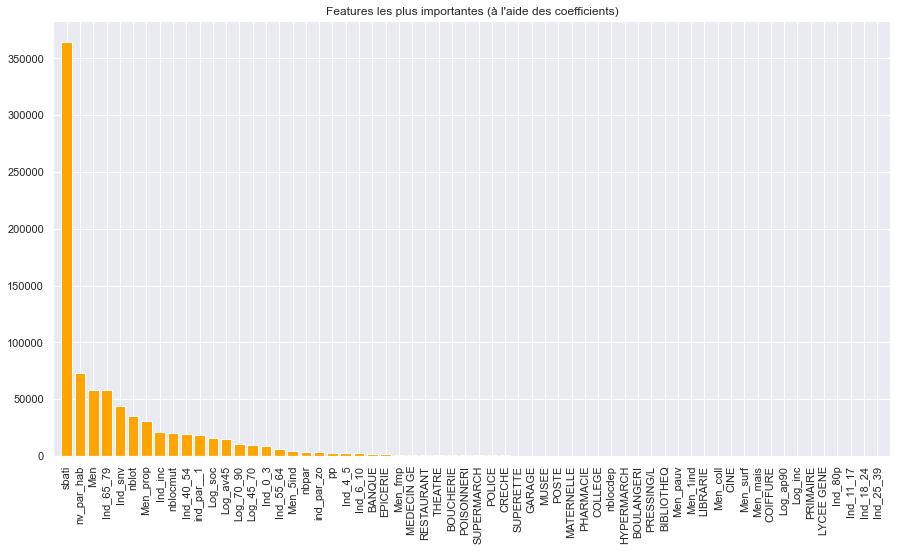

In [10]:
importance_feature= np.abs(lasso.coef_)
indices= np.argsort(importance_feature)[::-1]
lasso_importance_col= train_good_data.iloc[:, indices.tolist()].columns

plt.figure(figsize= (15, 8))

plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", align= "center")

plt.xticks(range(train_good_data.shape[1]),  lasso_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.title("Features les plus importantes (à l'aide des coefficients)")
plt.show()

### A l'aide d'un RandomForestRegressor naif

In [11]:
# Feature selection à l'aide d'un RandomForest
rf= RandomForestRegressor(verbose= 1, n_jobs= 10).fit(train_good_data, train_label)
sf_rf= SelectFromModel(rf, prefit= True)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.7min finished


In [12]:
selected_feat_rf= train_good_data.columns[(sf_rf.get_support())]
print(len(selected_feat_rf))
print(selected_feat_rf)

5
Index(['nblot', 'sbati', 'Ind_65_79', 'Ind_80p', 'nv_par_hab'], dtype='object')


In [13]:
importance_feature= rf.feature_importances_
std= np.std([i.feature_importances_ for i in rf.estimators_], axis=0)
indices= np.argsort(importance_feature)[::-1]

rf_importance_col= train_good_data.iloc[:, indices.tolist()].columns

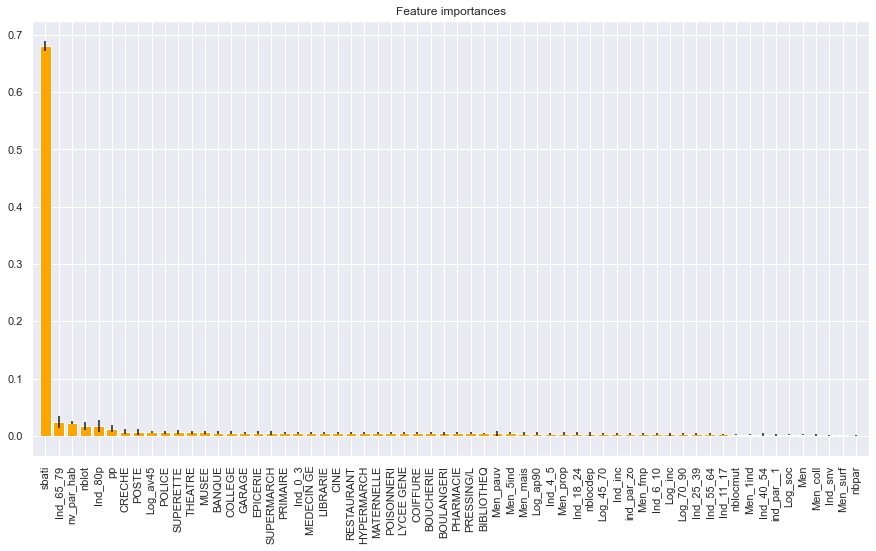

In [14]:
plt.figure(figsize= (15, 8))

plt.title("Feature importances")
plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", yerr= std[indices], align= "center")
plt.xticks(range(train_good_data.shape[1]),  rf_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.show()

## Développement de la Pipeline avec XGBoost

In [ ]:
xgb_regressor= xgb.XGBRegressor(eval_metric= "mae")

pipeline= Pipeline([
    ('standard_scaler', StandardScaler()),
    ('model', xgb_regressor)
])